In [59]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [60]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']
keep_cols = [c for c in train.columns if c not in drop_cols]

In [61]:
cat_cols = ['Sex', 'Embarked']
cont_cols = ['Age']

In [62]:
from sklearn.preprocessing import LabelEncoder

In [82]:
def process_data_train(X, keep_cols, cat_cols, cont_cols):
    X = X[keep_cols].copy()
    for c in cat_cols:
        X[c] = X[c].astype(str)
        
    lencoders = {}
    for c in cat_cols:
        lencoders[c] = LabelEncoder()
        X[c] = lencoders[c].fit_transform(X[c])
    
    means = {}
    for c in cont_cols:
        means[c] = X[c].mean()
        X[f'{c}Missing'] = X[c].isnull()
        X[c] = X[c].fillna(means[c])
    return X, lencoders, means

In [83]:
def process_data_test(X, keep_cols, cat_cols, lencoders,
                        means):
    X = X[keep_cols].copy()
    for c in cat_cols:
        X[c] = X[c].fillna('S').astype(str)
    for c in cat_cols:
        X[c] = lencoders[c].transform(X[c])
    for c in cont_cols:
        X[f'{c}Missing'] = X[c].isnull()
        X[c] = X[c].fillna(means[c])
    return X

In [84]:
X, lencoders, means = process_data_train(train, 
                        keep_cols, cat_cols, cont_cols)

In [85]:
X_test = process_data_test(test, keep_cols, cat_cols,
                      lencoders, means)

## Train - validation split

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
trn, val = train_test_split(train, test_size=0.2, 
                            random_state=100)

In [88]:
X_trn, lencoders, means = process_data_train(trn, 
                        keep_cols, cat_cols, cont_cols)
X_val = process_data_test(val, keep_cols, cat_cols,
                      lencoders, means)

In [89]:
len(trn), len(val), len(train)

(712, 179, 891)

In [90]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [91]:
tree.fit(X_trn, trn.Survived)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [92]:
from sklearn.metrics import accuracy_score

In [93]:
y_trn = tree.predict(X_trn)
y_val = tree.predict(X_val)
trn_acc = accuracy_score(trn.Survived, y_trn)
val_acc = accuracy_score(val.Survived, y_val)
print(f'Train: {trn_acc:.2%} | Val: {val_acc:.2%}')

Train: 98.74% | Val: 77.65%


In [94]:
y_trn = tree.predict(X_trn)
y_val = tree.predict(X_val)
trn_acc = accuracy_score(trn.Survived, y_trn)
val_acc = accuracy_score(val.Survived, y_val)
print(f'Train: {trn_acc:.2%} | Val: {val_acc:.2%}')

Train: 98.74% | Val: 77.65%


In [95]:
from sklearn.model_selection import KFold

In [96]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

In [98]:
import numpy as np

In [139]:
def cross_val(train, model, s):
    mean_val_acc = []
    for trn_idx, val_idx in kfolds.split(train):
        trn, val = train.iloc[trn_idx], train.iloc[val_idx]
        X_trn, lencoders, means = process_data_train(trn, 
                                keep_cols, cat_cols, cont_cols)
        X_val = process_data_test(val, keep_cols, cat_cols,
                              lencoders, means)
        
        model.fit(X_trn, trn.Survived)
        y_trn = model.predict(X_trn)
        y_val = model.predict(X_val)
        trn_acc = accuracy_score(trn.Survived, y_trn)
        val_acc = accuracy_score(val.Survived, y_val)
        mean_val_acc.append(val_acc)
#         print(f'Train: {trn_acc:.2%} | Val: {val_acc:.2%}')
    print(f'Mean val: {np.mean(mean_val_acc):.2%} | ', s)

In [104]:
tree = DecisionTreeClassifier()
cross_val(train, tree)

Train: 98.03% | Val: 78.21%
Train: 98.32% | Val: 74.72%
Train: 98.60% | Val: 82.58%
Train: 98.88% | Val: 75.84%
Train: 98.60% | Val: 80.34%
Mean val: 78.34%


In [105]:
tree = DecisionTreeClassifier(max_depth=5)
cross_val(train, tree)

Train: 85.11% | Val: 79.89%
Train: 84.29% | Val: 79.78%
Train: 83.73% | Val: 87.08%
Train: 85.83% | Val: 79.78%
Train: 84.85% | Val: 80.34%
Mean val: 81.37%


In [117]:
for min_samples_split in [5, 10, 20, 30]:
    for max_depth in [5, 10, 15, 20, 30]:
        tree = DecisionTreeClassifier(max_depth=max_depth,
                                      min_samples_split=min_samples_split)
        s = f'min_samples_split = {min_samples_split} | max_depth = {max_depth}'
        cross_val(train, tree, s)

Mean val: 81.48% |  min_samples_split = 5 | max_depth = 5
Mean val: 80.81% |  min_samples_split = 5 | max_depth = 10
Mean val: 79.46% |  min_samples_split = 5 | max_depth = 15
Mean val: 79.01% |  min_samples_split = 5 | max_depth = 20
Mean val: 79.91% |  min_samples_split = 5 | max_depth = 30
Mean val: 81.48% |  min_samples_split = 10 | max_depth = 5
Mean val: 81.37% |  min_samples_split = 10 | max_depth = 10
Mean val: 81.14% |  min_samples_split = 10 | max_depth = 15
Mean val: 81.03% |  min_samples_split = 10 | max_depth = 20
Mean val: 80.92% |  min_samples_split = 10 | max_depth = 30
Mean val: 81.15% |  min_samples_split = 20 | max_depth = 5
Mean val: 82.94% |  min_samples_split = 20 | max_depth = 10
Mean val: 82.94% |  min_samples_split = 20 | max_depth = 15
Mean val: 82.94% |  min_samples_split = 20 | max_depth = 20
Mean val: 82.94% |  min_samples_split = 20 | max_depth = 30
Mean val: 80.02% |  min_samples_split = 30 | max_depth = 5
Mean val: 81.03% |  min_samples_split = 30 | max_

In [119]:
for i in range(20):
    max_depth = np.random.randint(5, 31)
    min_samples_split = np.random.randint(5, 31)
    tree = DecisionTreeClassifier(max_depth=max_depth,
                                  min_samples_split=min_samples_split)
    s = f'min_samples_split = {min_samples_split} | max_depth = {max_depth}'
    cross_val(train, tree, s)

Mean val: 81.25% |  min_samples_split = 10 | max_depth = 16
Mean val: 80.59% |  min_samples_split = 8 | max_depth = 15
Mean val: 81.48% |  min_samples_split = 9 | max_depth = 5
Mean val: 83.73% |  min_samples_split = 14 | max_depth = 9
Mean val: 82.49% |  min_samples_split = 18 | max_depth = 24
Mean val: 79.57% |  min_samples_split = 5 | max_depth = 28
Mean val: 82.60% |  min_samples_split = 12 | max_depth = 17
Mean val: 82.15% |  min_samples_split = 25 | max_depth = 29
Mean val: 82.38% |  min_samples_split = 18 | max_depth = 17
Mean val: 82.94% |  min_samples_split = 13 | max_depth = 10
Mean val: 82.60% |  min_samples_split = 23 | max_depth = 20
Mean val: 83.05% |  min_samples_split = 21 | max_depth = 25
Mean val: 83.05% |  min_samples_split = 20 | max_depth = 21
Mean val: 79.57% |  min_samples_split = 5 | max_depth = 25
Mean val: 80.81% |  min_samples_split = 30 | max_depth = 24
Mean val: 83.05% |  min_samples_split = 15 | max_depth = 17
Mean val: 80.81% |  min_samples_split = 30 | m

# Random Forest

In [123]:
import multiprocessing as mp
mp.cpu_count()

8

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
for i in range(20):
    max_depth = np.random.randint(5, 31)
    min_samples_split = np.random.randint(5, 31)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_features=6,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_jobs=-1
    )
    s = f'min_samples_split = {min_samples_split} | max_depth = {max_depth}'
    cross_val(train, rf, s)

Mean val: 82.83% |  min_samples_split = 16 | max_depth = 12
Mean val: 83.95% |  min_samples_split = 6 | max_depth = 7
Mean val: 82.27% |  min_samples_split = 26 | max_depth = 30
Mean val: 83.05% |  min_samples_split = 15 | max_depth = 16
Mean val: 81.93% |  min_samples_split = 24 | max_depth = 28
Mean val: 83.39% |  min_samples_split = 11 | max_depth = 17
Mean val: 83.62% |  min_samples_split = 9 | max_depth = 11
Mean val: 83.05% |  min_samples_split = 19 | max_depth = 26
Mean val: 82.61% |  min_samples_split = 17 | max_depth = 24
Mean val: 82.16% |  min_samples_split = 17 | max_depth = 27
Mean val: 82.49% |  min_samples_split = 27 | max_depth = 13
Mean val: 82.04% |  min_samples_split = 30 | max_depth = 18
Mean val: 83.06% |  min_samples_split = 20 | max_depth = 19
Mean val: 82.27% |  min_samples_split = 29 | max_depth = 14
Mean val: 82.83% |  min_samples_split = 18 | max_depth = 16
Mean val: 82.27% |  min_samples_split = 26 | max_depth = 22
Mean val: 82.61% |  min_samples_split = 25 

# Gradient Boosting

In [129]:
# sklearn gradient boosting
# xgboost
# lightgbm
# catboost

In [133]:
from lightgbm import LGBMClassifier

In [142]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [144]:
for i in range(20):
    max_depth = np.random.randint(5, 31)
    min_samples_split = np.random.randint(5, 31)
    lgbm = LGBMClassifier(max_depth=max_depth)
    s = f'min_samples_split = {min_samples_split} | max_depth = {max_depth}'
    cross_val(train, lgbm, '')

Mean val: 82.60% |  
Mean val: 82.27% |  
Mean val: 82.94% |  
Mean val: 82.72% |  
Mean val: 82.27% |  
Mean val: 83.05% |  
Mean val: 83.50% |  
Mean val: 82.27% |  
Mean val: 82.72% |  
Mean val: 82.27% |  
Mean val: 82.27% |  
Mean val: 82.27% |  
Mean val: 82.27% |  
Mean val: 82.27% |  
Mean val: 82.27% |  
Mean val: 83.17% |  
Mean val: 82.94% |  
Mean val: 82.60% |  
Mean val: 82.27% |  
Mean val: 82.27% |  


## Metrics

In [147]:
trn, val = train_test_split(train, test_size=0.2, 
                            random_state=100)

In [148]:
X_trn, lencoders, means = process_data_train(trn, 
                        keep_cols, cat_cols, cont_cols)
X_val = process_data_test(val, keep_cols, cat_cols,
                      lencoders, means)

In [149]:
lgbm.fit(X_trn, trn.Survived)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=29,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [152]:
y_pred = lgbm.predict(X_val)

In [154]:
from sklearn.metrics import confusion_matrix, classification_report

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

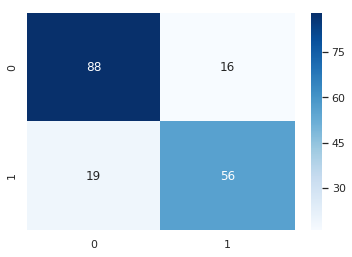

In [164]:
sns.heatmap(confusion_matrix(val.Survived, y_pred),
            cmap='Blues', annot=True);

In [156]:
val.Survived.value_counts()

0    104
1     75
Name: Survived, dtype: int64

In [165]:
print(classification_report(val.Survived, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.85      0.83       104
          1       0.78      0.75      0.76        75

avg / total       0.80      0.80      0.80       179



In [168]:
y_prob = lgbm.predict_proba(X_val)[:,1]

In [171]:
y_pred = y_prob > 0.8

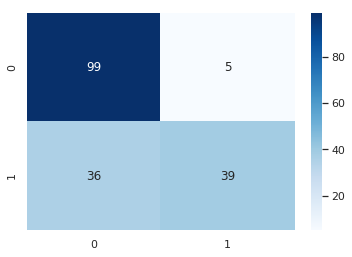

In [172]:
sns.heatmap(confusion_matrix(val.Survived, y_pred),
            cmap='Blues', annot=True);

In [173]:
print(classification_report(val.Survived, y_pred))

             precision    recall  f1-score   support

          0       0.73      0.95      0.83       104
          1       0.89      0.52      0.66        75

avg / total       0.80      0.77      0.76       179



In [176]:
y_pred = y_prob > 0.1

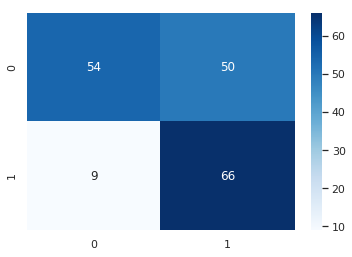

In [177]:
sns.heatmap(confusion_matrix(val.Survived, y_pred),
            cmap='Blues', annot=True);

In [178]:
print(classification_report(val.Survived, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.52      0.65       104
          1       0.57      0.88      0.69        75

avg / total       0.74      0.67      0.67       179



In [179]:
accuracy_score(val.Survived, y_pred)

0.6703910614525139

In [180]:
val.Survived.value_counts(normalize=True)

0    0.581006
1    0.418994
Name: Survived, dtype: float64

In [181]:
train.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64